In [1]:
import sys
import os
import random
import math
import logging
import time
from tqdm.notebook import tqdm

sys.path.append('../lib')

import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import distance
from IPython.display import clear_output
import time
from ocp import *
from costs import *
from ocp_utils import *
from env_creator import EnvCreator, generate_sdf_rep
from tensor_decomp import apply_tt
from visualization_utils import plot_traj_projections, plot_traj_and_obs_3d

import pybullet as p
import pybullet_data

%load_ext autoreload
%autoreload 2
np.set_printoptions(precision=4, suppress=True)

## Steps of trajectory optimization 

1. Define the dynamical system (e.g., double integrator, 2d robot, n-d manipulator, etc.)
2. Define the cost functions
3. Construct the ILQR problem
4. Solve

## Pybullet helpers

## iLQR functions 

### Setup the ILQR & Solve

In [2]:
### Define system and timesteps 

T = 100 # number of timesteps 
Dx, Du = 6, 3 #dimensions of x and u

x0 = np.array([-1,-1,-1,0,0,0])
x_target = np.array([1, 1, 1, 0,0, 0])
x_w = np.array([0,0,-1,0,0,0])
print("Start config: {}\nTarget config: {}\nVia: {}".format(x0, x_target, x_w))

# Define obstacles 
obstacles = []
obs1 = {
    'pos': np.array([0.01, 0., 0.]), # obstacle position
    'rad': 0.75,                     # radius of the obstacle 
    'w': 100.,                       # weight of obstacle cost
    'd_marg': 0.1                    # margin of obstacle
    }
obstacles.append(obs1)

# set ilqr params 
max_iterations = 100

Start config: [-1 -1 -1  0  0  0]
Target config: [1 1 1 0 0 0]
Via: [ 0  0 -1  0  0  0]


In [3]:
# Setup and solve problem 
prob, lin_sys = setup_ilqr(T, x0, x_target, obstacles)

In [4]:
# get standard initialization
# xs_init, us_init = create_standard_init(lin_sys, x0, T)


##Init using linear interpolation:
xs_init, us_init = create_linear_init(x0, x_target, T)

##init using waypoint:
# x_waypoint = np.array([0,0,-1,0,0,0])
# xs_init, us_init = create_waypoint_init(x0, x_waypoint, x_target,  T)

In [5]:
xs, us, ddp = solve_ilqr(prob, xs_init, us_init, iterations=max_iterations, th_grad = 1e-9, th_stop = 1e-9)

### Show the setting & plot trajectory in pybullet 

In [8]:
p.connect(p.GUI)
# p.connect(p.DIRECT)
p.setAdditionalSearchPath(pybullet_data.getDataPath())

p.configureDebugVisualizer(p.COV_ENABLE_GUI, 0)

In [9]:
obj_id, init_id, target_id, border_id, obstacle_ids = init_pybullet(x0, x_target, obstacles)

In [10]:
plot_traj(xs, obj_id, dt=0.01)

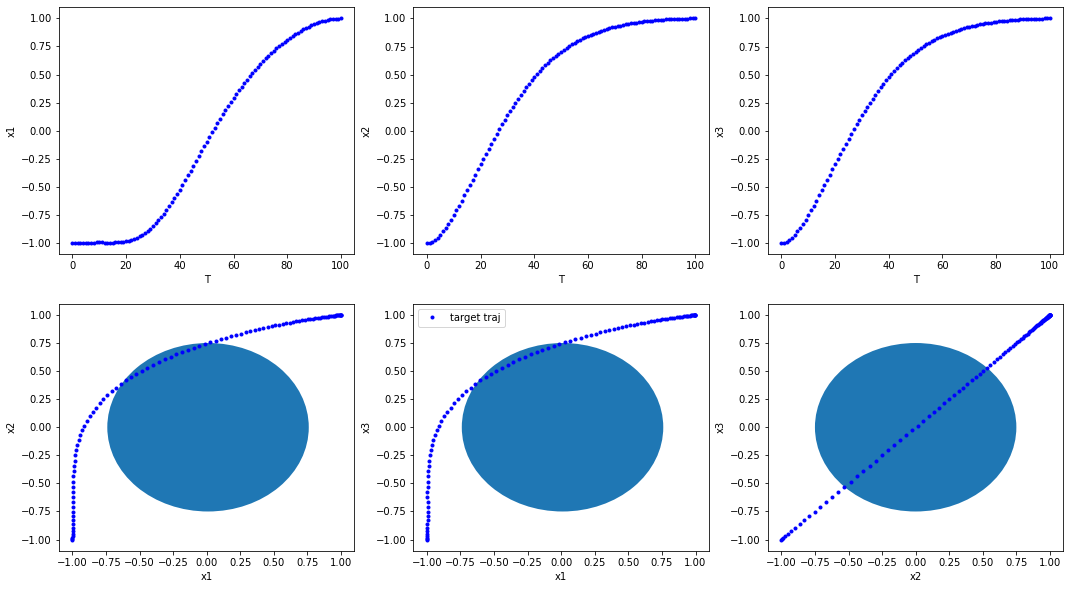

In [11]:
plot_traj_projections(xs, obstacles)

***

## Data generation 

### Fixed init & goal, random single obstacle

In [12]:
xrange = (-0.5, 0.7)
yrange = (-0.5, 0.7)
zrange = (-0.5, 0.7)

num_samples = 30

obs_positions = []
[obs_positions.append(np.array(
    [random.uniform(*xrange), 
     random.uniform(*yrange), 
     random.uniform(*zrange)])) 
 for i in range(num_samples) ]


num_radii = 10
radii = np.linspace(0.4, 0.9, num_radii)
# radii = [0.4, 0.5, 0.6, 0.7, 0.8]

# experiment_name = 'start_goal_fixed_100pos_5rad'
experiment_name = 'start_goal_fixed_300samples_1'

In [13]:
log_file = '../data/envs/%s/data_generation.txt'%experiment_name
os.makedirs(os.path.dirname(log_file), exist_ok=True)
logging.basicConfig(filename=log_file)# , encoding='utf-8', level=logging.DEBUG)#, force=True)

In [50]:
w_obs = 100.   # weight of the obstacle cost
d_margin = 0.1 # margin of the obstacle
target_thres = 0.1 # does it reach target close enough -> target status (bool)
T = 100
success_track = []
via_point = np.array([0,0,-1,0,0,0]) # bias 

exp_idx = 0 
num_experiments = len(radii) * len(obs_positions)

with tqdm(total=num_experiments) as pbar:
    for i1 in tqdm(range(len(obs_positions))):
        pbar.update(1)
        for i2 in tqdm(range(len(radii)),leave = False):
            pbar.update(1)
            pos = obs_positions[i1]
            rad = radii[i2]
            exp_obstacles = [{'pos': pos, 'rad': rad, 'w': w_obs, 'd_marg': d_margin}]
            exp_idx += 1 

            exp_info = '\n------------\n Exp_id:{}\n\np_obs:{}\nr_obs:{}'.format(exp_idx, pos, rad)
            logging.info(exp_info)

            # Setup and solve problem 
            prob, lin_sys = setup_ilqr(T, x0, x_target, exp_obstacles)
            xs_init, us_init = create_linear_init(x0, x_target, T)
            # xs_init, us_init = create_waypoint_init(x0, via_point, x_target,  T)
            xs, us, ddp = solve_ilqr(prob, xs_init, us_init, iterations=max_iterations, th_grad = 1e-9, th_stop = 1e-9)
            
            #check status
            status, target_status, collision_status, dist_obstacles, obs_thresholds = check_cost(ddp, target_thres, exp_obstacles, T)
            status_info = 'Reach target: {}\nNo collision: {}\nSUCCESS: {}'.format(target_status, collision_status, status)
            logging.info(status_info)
            success_track.append(status)

            # save 
            data = dict()
            data['xs'], data['us'] = np.array(ddp.xs), np.array(us)
            data['x0'], data['xT'], data['x_w'] = x0, x_target, via_point
            data['obstacles'] = exp_obstacles
            data['status'], data['target_status'], data['collision_status'] = status, target_status, collision_status
            data['dist_obstacles'] = dist_obstacles
            data['target_thres'], data['obstacle_threshs'] = target_thres, obs_thresholds
            data['iter'], data['cost'] = ddp.iter, ddp.cost
#             np.save('../../data/envs/{}/data_exp{}.npy'.format(experiment_name,exp_idx), data)        

print('Success rate is {}'.format(np.sum(success_track)/(exp_idx+1)))

#### Vary start and goal position 

In [15]:
exp_name = 'var_start_goal_1000samples'
log_file = '../data/envs/%s/data_generation.txt'%exp_name
os.makedirs(os.path.dirname(log_file), exist_ok=True)
# logging.basicConfig(filename=log_file, encoding='utf-8', level=logging.DEBUG, force=True)

In [16]:
# include check that start and goal don't coincide / have a certain distance to eachother 
xrange1 = (-1., -0.3)
yrange1 = (-1., -0.3)
zrange1 = (-1., -0.3)

xrange2 = (0.3, 1.)
yrange2 = (0.3, 1.)
zrange2 = (0.3, 1.)

num_samples = 100
init_pos = []
goal_pos = []

for i in range(num_samples): 
    init_pos.append(np.array([random.uniform(*xrange1), random.uniform(*yrange1), random.uniform(*zrange1),0,0,0])) 
    goal_pos.append(np.array([random.uniform(*xrange2), random.uniform(*yrange2), random.uniform(*zrange2),0,0,0]))

In [17]:
# adapt obstacle parameters 
xrange = (-0.5, 0.5)
yrange = (-0.5, 0.5)
zrange = (-0.5, 0.5)

num_positions = 100
num_radii = 5 

obs_positions = []
[obs_positions.append(np.array(
    [random.uniform(*xrange), 
     random.uniform(*yrange), 
     random.uniform(*zrange)])) 
 for i in range(num_positions) ]

radii = np.linspace(0.4, 0.8, num_radii)

In [ ]:
# Show distribution of sample points 
fig = plt.figure()
ax = fig.add_subplot(projection='3d')

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

x0_set = np.array(init_pos)
xT_set = np.array(goal_pos)
obs_set = np.array(obs_positions)
ax.scatter(x0_set[:,0], x0_set[:,1], x0_set[:,2], c='b')
ax.scatter(xT_set[:,0], xT_set[:,1], xT_set[:,2], c='r')
ax.scatter(obs_set[:,0], obs_set[:,1], obs_set[:,2], c='g')

plt.show()

In [39]:
w_obs = 100.   # weight of the obstacle cost
d_margin = 0.1 # margin of the obstacle
target_thres = 0.1 # does it reach target close enough -> target status (bool)
via_point = np.array([0,0,-1,0,0,0]) # bias 
success_track = []
T = 100

exp_idx = 0 
num_obs_pos = 10
num_experiments = num_obs_pos * len(init_pos)

with tqdm(total=num_experiments) as pbar:
    for i0 in tqdm(range(len(init_pos))): 
        pbar.update(1)
        x0 = init_pos[i0]
        x_target = goal_pos[i0]
        for i1 in tqdm(range(num_obs_pos), leave=False):
            pbar.update(1)
            exp_idx += 1 

            # randomly draw obstacle positions & radii
            pos = obs_positions[random.randint(0,len(obs_positions)-1)]
            rad = radii[random.randint(0,len(radii)-1)]
            exp_info = '\n------------\n Exp_id:{}\n\np_obs:{}\nr_obs:{}'.format(exp_idx, pos, rad)
            exp_obstacles = [{'pos': pos, 'rad': rad, 'w': w_obs, 'd_marg': d_margin}]

        
            # Setup and solve problem 
            prob, lin_sys = setup_ilqr(T, x0, x_target, exp_obstacles)
            xs_init, us_init = create_linear_init(x0, x_target, T)
            # xs_init, us_init = create_waypoint_init(x0, via_point, x_target,  T)
            xs, us, ddp = solve_ilqr(prob, xs_init, us_init, iterations=max_iterations, th_grad = 1e-9, th_stop = 1e-9)
        
            # check status             
            status, target_status, collision_status, dist_obstacles, obs_thresholds = check_cost(ddp, target_thres, exp_obstacles, T)
            status_info = 'Reach target: {}\nNo collision: {}\nSUCCESS: {}'.format(target_status, collision_status, status)
            logging.info(status_info)
            success_track.append(status)

            # save 
            data = dict()
            data['xs'] = np.array(ddp.xs)
            data['us'] = np.array(us)
            data['x0'] = x0
            data['xT'] = x_target
            data['x_w'] = via_point
            data['obstacles'] = exp_obstacles
            data['status'] = status
            data['target_status'] = target_status
            data['collision_status'] = collision_status
            data['dist_obstacles'] = dist_obstacles
            data['target_thres'] = target_thres
            data['obstacle_threshs'] = obs_thresholds
            data['iter'] = ddp.iter
            data['cost'] = ddp.cost
            np.save('../../data/envs/{}/data_exp{}.npy'.format(exp_name,exp_idx), data)                        

print('Success rate is {}'.format(np.sum(success_track)/(exp_idx+1)))

#### Introduce multiple obstacles 

In [3]:
fix_start_goal = False 
num_experiments = 1000
num_samples_pos = 500 # number of sample points 
num_samples_obs = 500 # number of sample points 
num_radii = 6

In [4]:
experiment_name = 'start_goal_fixed_100pos_5rad'
# experiment_name = 'mult_obs_var_start_goal_1000samples_1'
log_file = '../../data/envs/%s/data_generation.txt'%experiment_name
os.makedirs(os.path.dirname(log_file), exist_ok=True)

In [5]:
## Obstacle parameters 
# xrange = (-0.4, 0.4)
# yrange = (-0.4, 0.4)
# zrange = (-0.4, 0.4)
xrange = (-0.6, 0.6)
yrange = (-0.4, 0.4)
zrange = (-0.6, 0.6)

obs_positions = []
[obs_positions.append(np.array(
    [random.uniform(*xrange), 
     random.uniform(*yrange), 
     random.uniform(*zrange)])) 
 for i in range(num_samples_obs) ]

# radii = np.linspace(0.3, 0.7, num_radii)
radii = np.linspace(0.15, 0.5, num_radii)

In [6]:
if not fix_start_goal: 
    xrange1 = (-1., -0.4)
    yrange1 = (-1., -0.4)
    zrange1 = (-1., -0.4)

    xrange2 = (0.4, 1.)
    yrange2 = (0.4, 1.)
    zrange2 = (0.4, 1.)

    init_pos = []
    goal_pos = []

    for i in range(num_samples_pos): 
        init_pos.append(np.array([random.uniform(*xrange1), random.uniform(*yrange1), random.uniform(*zrange1),0,0,0])) 
        goal_pos.append(np.array([random.uniform(*xrange2), random.uniform(*yrange2), random.uniform(*zrange2),0,0,0]))

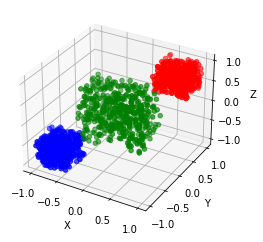

In [7]:
# Show distribution of sample points 
fig = plt.figure()
ax = fig.add_subplot(projection='3d')

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

if fix_start_goal: 
    x0_set = x0.reshape(-1, 6)
    xT_set = x_target.reshape(-1, 6)
else: 
    x0_set = np.array(init_pos)
    xT_set = np.array(goal_pos)
obs_set = np.array(obs_positions)
ax.scatter(x0_set[:,0], x0_set[:,1], x0_set[:,2], c='b')
ax.scatter(xT_set[:,0], xT_set[:,1], xT_set[:,2], c='r')
ax.scatter(obs_set[:,0], obs_set[:,1], obs_set[:,2], c='g')

plt.show()

In [13]:
w_obs = 100.   # weight of the obstacle cost
d_margin = 0.1 # margin of the obstacle
target_thres = 0.1 # does it reach target close enough -> target status (bool)
via_point = np.array([0,0,-1,0,0,0]) # bias 
success_track = []
num_obs_track = []
data_set = []
exp_idx = 0
num_experiments = 1000
T=100
max_iterations=250

for i in tqdm(range(num_experiments)): 
    if not fix_start_goal: 
        pos_idx = random.randint(0,len(init_pos)-1)
        x0 = init_pos[pos_idx]
        x_target = goal_pos[pos_idx]
    else: 
        x0 = np.array([-1., -1., -1., 0., 0., 0.])
        x_target = np.array([1., 1., 1., 0., 0., 0.])
    
    # set number of obstacles 
    num_obstacles = random.randint(3,5)  # shuffle the number of obstacles the environment should contain 
    num_obs_track.append(num_obstacles)
#     num_obstacles = 2 
    
    sample_obs_pos = []
    obs_radii = [radii[random.randint(0,len(radii)-1)] for i in range(num_obstacles)]

    for k in range(num_obstacles):
        obs_pos = obs_positions[random.randint(0,len(obs_positions)-1)] 
        
        if k >=1: 
            obs_dist = distance.euclidean(obs_pos, sample_obs_pos[k-1])  # if too close to previous obstacle, resample 
            goal_dist = distance.euclidean(obs_pos, x_target[:3])
            init_dist = distance.euclidean(obs_pos, x0[:3])
            start_goal_marg = obs_radii[k] + 0.05 # margin for obstacle to stay away from start and goal 
            while obs_dist < 0.5 and goal_dist < start_goal_marg and init_dist < start_goal_marg: 
                obs_pos = obs_positions[random.randint(0,len(obs_positions)-1)] 
        sample_obs_pos.append(obs_pos)

    exp_obstacles = [{'pos': obs[0], 'rad': obs[1], 'w': w_obs, 'd_marg': d_margin} for obs in zip(sample_obs_pos, obs_radii)]
    
    col_status_init, _ = check_collision(exp_obstacles, x0)
    col_status_goal, _ = check_collision(exp_obstacles, x_target)
    
    if col_status_init or col_status_goal:
        print('Init/goal collides with obstacle')
        continue
    
    
    exp_idx += 1 

    # Setup and solve problem 
    prob, lin_sys = setup_ilqr(T, x0, x_target, exp_obstacles)
#     xs_init, us_init = create_standard_init(lin_sys, x0, T)
#     xs_init, us_init = create_linear_init(x0, x_target, T)
    xs_init, us_init = create_waypoint_init(x0, via_point, x_target,  T)
    xs, us, ddp = solve_ilqr(prob, xs_init, us_init, iterations=max_iterations, th_grad = 1e-9, th_stop = 1e-9)
            
    # check status             
    status, target_status, collision_status, dist_obstacles, obs_thresholds = check_cost(ddp, target_thres, exp_obstacles, T)
    status_info = 'Reach target: {}\nNo collision: {}\nSUCCESS: {}'.format(target_status, collision_status, status)
    logging.info(status_info)
    success_track.append(status)

    # save 
    data = dict()
    data['xs'] = np.array(ddp.xs)
    data['us'] = np.array(us)
    data['x0'] = x0
    data['xT'] = x_target
    data['x_w'] = via_point
#             data['p_obs'] = obs['pos']
#             data['r_obs'] = obs['rad']
    data['obstacles'] = exp_obstacles
    data['status'] = status
    data['target_status'] = target_status
    data['collision_status'] = collision_status
    data['dist_obstacles'] = dist_obstacles
    data['target_thres'] = target_thres
    data['obstacle_threshs'] = obs_thresholds
    data['cost'] = ddp.cost
    data['iter'] = ddp.iter
    data_set.append(data)
    np.save('../../data/envs/{}/data_exp{}.npy'.format(experiment_name,exp_idx), data)        

print('Success rate is {}'.format(np.sum(success_track)/(exp_idx+1)))

#### Show the dataset

In [369]:
idx = np.random.randint(len(data_set))
data = data_set[idx]
obstacles =data['obstacles']
x0 = data['x0']
x_target = data['xT']
xs = data['xs']
obj_id, init_id, target_id, border_id, obstacle_ids = init_pybullet(x0, x_target, obstacles)
col_status, _ = eval_collision_geometric(obstacles, xs[:,:3])
print(np.max(col_status))

plot_traj(xs, obj_id, 0.01)

False


In [340]:
plot_traj(xs, obj_id, 0.02)
